In [13]:
import numpy as np
import scipy.optimize as op
import datetime
import emcee
import matplotlib.pyplot as plt
import corner
from scipy.stats import norm, halfnorm
from matplotlib import mlab
%matplotlib inline

In [14]:
mars = np.genfromtxt('data/harp_mars.dat', usecols=np.arange(0, 9))
jupiter = np.genfromtxt('data/harp_jupiter.dat', usecols=np.arange(0, 8))
uranus = np.genfromtxt('data/harp_uranus.dat', usecols=np.arange(0, 8))

In [15]:
mars_etamb = mars[:,5]
jupiter_etamb = jupiter[:,5]
uranus_etamb = uranus[:,5]

mars_dates = mars[:,0]
jupiter_dates = jupiter[:,0]
uranus_dates = uranus[:,0]

mars = mars[mars[:,1] > 5]
mars = mars[mars[:,1] < 19]
mars = mars[mars[:,5] > 0]
jupiter = jupiter[jupiter[:,1] > 5]
jupiter = jupiter[jupiter[:,1] < 19]
jupiter = jupiter[jupiter[:,5] > 0]
uranus = uranus[uranus[:,1] > 5]
uranus = uranus[uranus[:,1] < 19]
uranus = uranus[uranus[:,5] > 0]

planets_etamb = np.concatenate((mars_etamb, jupiter_etamb, uranus_etamb), axis=0)
raw_dates = np.concatenate((mars_dates, jupiter_dates, uranus_dates), axis=0)
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in raw_dates]

In [16]:
oldest = min(dates)
days = np.array([np.float64((date - oldest).days) + 1 for date in dates])

In [18]:
m_true = 0.0
b_true = .5

delty1_true = 0.0
delty2_true = 0.3
sigsq1_true = .01
sigsq2_true = .04
a1_true = .5
a2_true = .5
scale_true = .0001

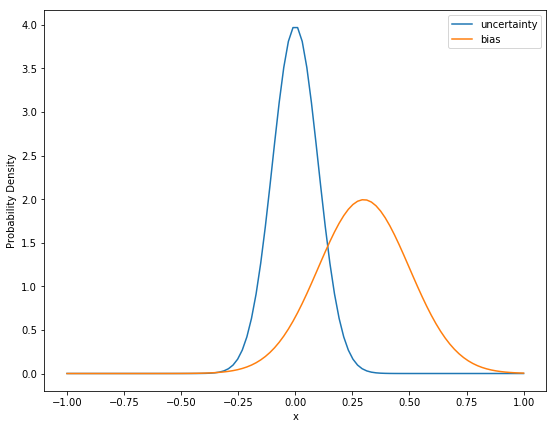

In [63]:
plt.figure(figsize=(9, 7))
x = np.linspace(-1.0, 1.0, 100)
plt.plot(x, norm.pdf(x, delty1_true, np.sqrt(sigsq1_true)), label='uncertainty')
plt.plot(x, norm.pdf(x, delty2_true, np.sqrt(sigsq2_true)), label='bias')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [20]:
def lnlike(theta, x, y):
    m, b, delty1, delty2, sigsq1, sigsq2, a1, scale = theta
    a2 = 1.0 - a1
    delty1 = 0
    delty2 = 0.3
#     sigsq1 = .01
    sigsq2 = (1/sigsq1) * scale
    mod1 = y + delty1 - m*x - b
    mod2 = y + delty2 - m*x - b
    return np.sum(np.log(((a1/(np.sqrt(2*np.pi*sigsq1)))*np.exp((-(mod1)**2)/(2*sigsq1))+ \
                           ((a2/(np.sqrt(2*np.pi*sigsq2)))*np.exp((-(mod2)**2)/(2*sigsq2)) ))))

In [23]:
def lnprior(theta):
    m, b, delty1, delty2, sigsq1, sigsq2, a1, scale = theta
    if 0.0 < b < 1.0 and 0.0 < a1 < 1.0 and sigsq1 > 0.0 and sigsq2 > 0.0 and scale > 0.0:
        pri_m = norm.logpdf(m, 0.0, 1.0)
#         pri_delty1 = norm.logpdf(delty1, 0.0, 0.5)
#         pri_delty2 = norm.logpdf(delty2, 0.3, 0.5)
        pri_sigsq1 = norm.logpdf(sigsq1, .01, .01)
#         pri_sigsq2 = norm.logpdf(sigsq2, .04, .01)
        pri_a1 = halfnorm.logpdf(a1, 0.0, 1.0/3.0)
        pri_scale = norm.logpdf(scale, .0001, .0001)
        return pri_m +pri_sigsq1 + pri_a1
    return -np.inf

In [24]:
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

In [25]:
ndim, nwalkers = 8, 200
pos = [np.random.randn(ndim)*1e-4*[0.001, .6, 0.0, 0.3, .01, .04, .5, .5] for i in range(nwalkers)]

In [44]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(days, planets_etamb), threads=4, a=2.0)

In [45]:
sampler.run_mcmc(pos, 1000)

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[ -4.98468573e-07,   5.66090555e-01,   0.00000000e+00, ...,
           1.10154474e+04,   8.95331069e-01,   8.88384551e-05],
        [ -6.96169114e-07,   5.71757313e-01,   0.00000000e+00, ...,
           3.60297861e+05,   8.60982195e-01,   6.73755564e-05],
        [  6.85575832e-06,   5.61788610e-01,   0.00000000e+00, ...,
           2.43589510e+05,   8.62755274e-01,   1.43741642e-04],
        ..., 
        [  6.39355063e-06,   5.67496744e-01,   0.00000000e+00, ...,
           1.53477221e+04,   8.91138301e-01,   8.09439681e-05],
        [ -2.54791432e-06,   5.77102260e-01,   0.00000000e+00, ...,
           4.74493896e+05,   8.83304473e-01,   7.87399548e-05],
        [  3.94981022e-07,   5.65655895e-01,   0.00000000e+00, ...,
           1.77430622e+05,   8.43663400e-01,   1.47580545e-04]]),
 array([ 489.57934668,  486.35380103,  485.31702658,  489.51342468,
         487.03885961,  483.12564992,  488.82622757,  487.68320448,
         489.70555544,  487.74641575,  487.66304574,  48

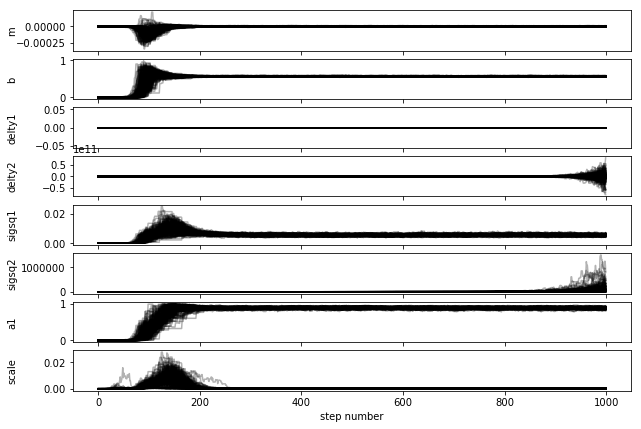

In [46]:
plt.figure(1)
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["m", "b", "delty1", "delty2", "sigsq1", "sigsq2", "a1", "scale"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
fig.savefig("200walkers_smallinit_a2.0_1000steps_nongauss_noscatter_2gauss_corr.png")
plt.show()

In [47]:
flat_samples = sampler.chain[:, 200:, :].reshape((-1, ndim))

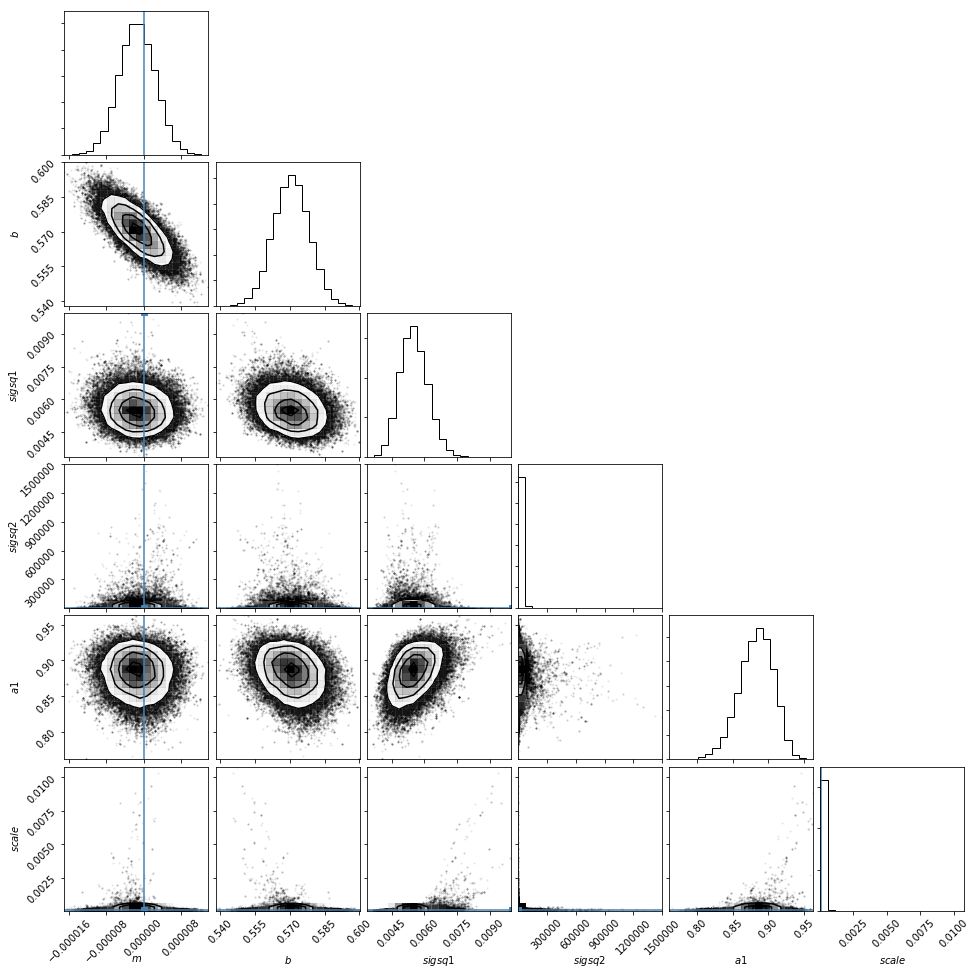

In [48]:
fig = corner.corner(flat_samples[:,[0, 1, 4, 5, 6, 7]], labels=["$m$", "$b$", "$sigsq1$", "$sigsq2$", "$a1$", "$scale$"],
                      truths=[m_true, b_true, sigsq1_true, sigsq2_true, a1_true, scale_true])
fig.savefig("200walkers_smallinit_a2.0_1000steps_nongauss_noscatter_corner_2gauss_corr.png")

In [49]:
from IPython.display import display, Math
results = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    results.append(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

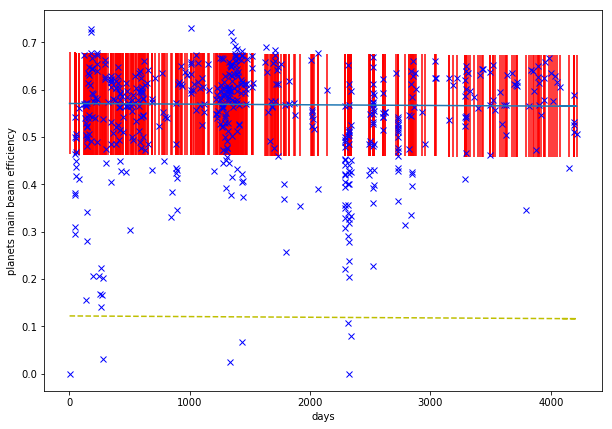

In [59]:
plt.figure(figsize=(10,7))
plt.plot(days, planets_etamb, 'bx')
m = results[0][1]
b = results[1][1]
y = m*days + b
yerr = .1 + results[1][1]-np.absolute(results[1][0])
bias = results[3][1] 
plt.xlabel('days')
plt.ylabel('main beam efficiency')
plt.errorbar(days, y, yerr=yerr, ecolor='red')
plt.errorbar(days, y + bias, fmt='--', color='y')
plt.show()